# map dashboard with bokeh and panel

## interactions

- [x] selection of points: get selected dataframe
- [x] get a tree from subset of samples
    - requires snp matrix for samples
    - use encoded snps in the database
- [ ] show clustermap of snp distances
- [ ] closely related isolates only
- [x] draw selected samples from multiselect on map
- [ ] fix aspect ration for manual zoom
- [ ] show SNP data?
- [ ] show movement type data?

In [991]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
import sqlite3
import toytree, toyplot
import random
from snipgenie import trees, app, tools, snp_typing


In [992]:
css = '''
.bk.panel-widget-box {
  background: #f0f0f0;
  border-radius: 5px;
  border: 1px black solid;
}
'''

In [993]:
from collections import OrderedDict
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Slider
from bokeh.plotting import figure
from bokeh.themes import Theme
from bokeh.io import show, output_notebook
from bokeh.models import (DataTable, GeoJSONDataSource, ColumnDataSource, HoverTool, renderers,
                          Label, LabelSet, CustomJS, MultiSelect, Dropdown, Div, Range1d)
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension(raw_css=[css])

Loading BokehJS ...

In [994]:
tree_style = {
    "layout":'r',
    "edge_type": 'p',
    "edge_style": {
        "stroke": 'black',
        "stroke-width": 2,
    },
    "tip_labels": True,
    "tip_labels_align": True,
    "tip_labels_colors": 'black',
    "tip_labels_style": {
        "font-size": "14px"
    },
    "node_labels": False,
    "node_sizes": 10,
    "node_colors": toytree.colors[2],
    "node_markers":"c",
    "use_edge_lengths":True,
}

template = """
{% extends base %}

<!-- goes in body -->
{% block postamble %}
<link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/css/bootstrap.min.css">
{% endblock %}

<!-- goes in body -->
{% block contents %}
{{ app_title }}
<p>This is a Panel app with a custom template allowing us to compose multiple Panel objects into a single HTML document.</p>
<br>
<div class="container">
  <div class="row">
    <div class="col-sm">
      {{ embed(roots.A) }}
    </div>
    <div class="col-sm">
      {{ embed(roots.B) }}
    </div>
  </div>
</div>
{% endblock %}
"""

In [5]:
def test_map():
    tile_provider = get_provider(CARTODBPOSITRON)
    # range bounds supplied in web mercator coordinates
    p = figure(x_range=(-2000000, 6000000), y_range=(-1000000, 7000000),
               x_axis_type="mercator", y_axis_type="mercator")
    p.add_tile(tile_provider)
    return p

#p=test_map()
#show(p)

## test data - should read from db later

In [1142]:
df = pd.read_csv('ireland_test_data.csv')
df = df.fillna('')
#p=bokeh_map(df)
#df[df.species.isnull()]

In [7]:
#read from db
con = sqlite3.connect("test.sqlite")
cur = con.cursor()
#df = pd.read_sql_query("SELECT * from isolates", con)

In [995]:
species_colors = {'Cow':'green', 'Badger':'blue', 'Deer':'red','Dog':'orange'}
sb_colors = trees.colors_from_labels(df,'name','spoligotype')
clade_colors = {'Monaghan-1':'brown','Monaghan-2':'orange','Monaghan-3':'red','Wicklow-1':'green','NI-1':'blue','Unknown':'gray','':'gray'}
county_colors = trees.colors_from_labels(df,'name','county')
cmaps = {'species': species_colors,'spoligotype':sb_colors,'clade':clade_colors,'county':county_colors}
providers = ['CARTODBPOSITRON','STAMEN_TERRAIN','OSM','ESRI_IMAGERY']

In [996]:
df.clade.unique()
df.spoligotype.unique()
colormap = trees.colors_from_labels(df,'name','clade')
colormap

{'NI-1': 'blue',
 'Wicklow-1': 'green',
 'Monaghan-3': 'crimson',
 '': 'blueviolet',
 'Monaghan-1': 'brown',
 'Monaghan-2': 'burlywood',
 'Unknown': 'cadetblue'}

In [997]:
def wgs84_to_web_mercator(df, lon="LON", lat="LAT"):

      k = 6378137
      df["x"] = df[lon] * (k * np.pi/180.0)
      df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
      return df

In [998]:
def sample_tree(n=10):

    import toytree
    tre = toytree.rtree.coaltree(n)
    ## assign random edge lengths and supports to each node
    for node in tre.treenode.traverse():
        node.dist = np.random.exponential(1)
        node.support = int(np.random.uniform(50, 100))

    canvas,axes,mark = tre.draw(
                    width=350,
                    height=500,
                    scalebar=True, **tree_style)
    toyplot.html.render(canvas, "tree.html")
    return

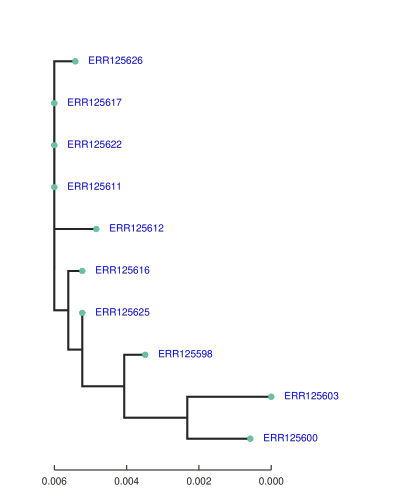

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="700.0px" height="275.0px" viewBox="0 0 700.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tac93123dc6d34573b67c90df7561947d"> ERR125600 ERR125603 ERR125598 ERR125625 ERR125616 ERR125612 ERR125611 ERR125622 ERR125617 ERR125626

In [1123]:
def get_tree(df):
    """Get a tree from a selection of samples
       uses encoded snp data from dataframe/db to make a distance matrix
    """
    
    #decode snps
    snpmat = df.snps.apply(snp_typing.decode_snps)
    snpmat.index = df.name
    #print (snpmat[:4])  
    tre = snp_typing.tree_from_snps(snpmat.T)    
    return tre

def draw_tree(tre, df, colorby=None, layout='r', font_size=10, root=None, **kwargs):
    """draw the tree with given options"""

    if root not in ['',None]:
        tre = tre.root(root)
    tipnames = tre.get_tip_labels()  
    node_colors = None
    node_sizes = None
    if colorby not in ['',None]:
        mapping = dict(zip(df.name,df[colorby]))
        colormap =  cmaps[colorby]        
        tip_colors = [colormap[mapping[i]] if (i in mapping and i!='') else 'gray' for i in tipnames]
        node_sizes=[0 if i else 6 for i in tre.get_node_values(None, 1, 0)]
        if len(tipnames)>40:
            
            node_colors = [colormap[mapping[n]] if n in mapping else 'gray' for n in tre.get_node_values('name', True, True)]
            tipnames = ['' for i in tipnames]  
    else:
        tip_colors = None
    tip_labels_style={      
            "font-size": "%spx" %font_size,
            "-toyplot-anchor-shift": "13px",
        }
    #render to html
    canvas, axes, mark = tre.draw(tip_labels=tipnames, tip_labels_colors=tip_colors,tip_labels_style=tip_labels_style,
                                  layout=layout,node_colors=node_colors,node_sizes=node_sizes,node_hover=True,
                                  scalebar=True, width=400, height=500, **kwargs);   
    toyplot.html.render(canvas, "tree.html");
    return canvas

tre = get_tree(df[:10])
draw_tree(tre,df,'clade')

In [1038]:
def dist_matrix(df):
    """Distance matrix from nuc SNP matrix"""
     
    snpmat = df.snps.apply(snp_typing.decode_snps)
    names = snpmat.index = df.name
    M=[]
    for i,r in snpmat.iterrows():
        x=[]
        s1 = ''.join(r)
        for i,r in snpmat.iterrows():
            s2=''.join(r)        
            m = [1 for x,y in zip(s1,s2) if x!=y]
            #print (m)
            x.append(sum(m))
        M.append(x)
    M = pd.DataFrame(M,index=names,columns=names)
    return M

dist_matrix(df[:4])

name,ERR125617,ERR125622,ERR125598,ERR125612
name,,,,
ERR125617,0,0,4,2
ERR125622,0,0,4,2
ERR125598,4,4,0,6
ERR125612,2,2,6,0


In [ ]:
def dist_plot(dist):
    import seaborn as sns
    
    annot=False
    if len(dist)<12:
        annot=True
    g=sns.clustermap(dist,annot=annot,fmt='.0f',xticklabels=True,yticklabels=True,cmap='Blues',figsize=(10,10))
    return g.fig

m=dist_matrix(df[80:90])   
f=dist_plot(m)

In [1002]:
def bokeh_map(df=None, long=None, lat=None,
              tile_provider='CARTODBPOSITRON', colorby='species',
              labels=None):
    """Bokeh map"""
    
    tile_provider = get_provider(tile_provider)
    tools = "pan,wheel_zoom,box_zoom,hover,tap,lasso_select,reset,save"
    sizing_mode='stretch_both'
    
    # range bounds supplied in web mercator coordinates
    k = 6378137
    if lat == None:
        lat = 53.5
    if long == None:
        long = -7

    #get coords
    x = long * (k * np.pi/180.0)
    y = np.log(np.tan((90 + lat) * np.pi/360.0)) * k
    df = wgs84_to_web_mercator(df, lon="LONG", lat="LAT")
    colormap = cmaps[colorby]
    df['color'] = [colormap[i] if i in colormap else 'gray' for i in df[colorby]] 
    df['label'] = ''
    source = ColumnDataSource(df)
    #draw figure
    p = figure(x_range=(x-200000, x+200000), y_range=(y-200000, y+200000),
               x_axis_type="mercator", y_axis_type="mercator", tools=tools,
               plot_width=500, plot_height=500, sizing_mode=sizing_mode)   
    p.add_tile(tile_provider)
    p.circle(x='x', y='y', size=15, alpha=0.7, color='color', source=source)#, legend_group=colorby)

    labels = LabelSet(x='x', y='y', text='label',text_font_size='10pt',
                     x_offset=5, y_offset=5, source=source, render_mode='canvas')
    p.add_layout(labels)
    p.toolbar.logo = None
    p.match_aspect = True
    hover = p.select(dict(type=HoverTool))
    hover.tooltips = OrderedDict([
        ("name", "@name"),
        ("species", "@species"),
        ("spoligotype", "@spoligotype"),
        ("clade", "@clade"),     
        ("nearest", "@nearest"), 
        ("county", "@county"),
    ])    
    return p

In [1003]:
style1 = {'background':'#f5f5d6','padding':'5px','font':'monospace'}

In [1147]:
def map_dash():
    """Map dashboard"""

    names = sorted(list(df.name.unique()))
    tre = None
    sel = None
    cols = df.columns[:6]
    cats=['species','clade','spoligotype','county']
    labels=['','name','clade']
    map_pane = pn.pane.Bokeh(width=400)    
    tree_pane = pn.pane.HTML(width=300)
    plot_pane = pn.pane.Matplotlib(height=500)
    
    tree_layout_select = pnw.Select(name='tree layout',options=['r','c','d'],width=200)
    root_select = pnw.Select(name='root on',options=[''],width=200)
    tile_select = pnw.Select(name='tile layer',options=providers,width=200)
    colorby_select = pnw.Select(name='color by',options=cats,width=200)
    label_select = pnw.Select(name='label',options=labels,width=200)
    name_select = pnw.MultiSelect(name='name',options=names,size=8,width=200)
    btn = pnw.Button(name='Reset', button_type='primary',width=200)
    info_pane = pn.pane.HTML(style=style1,width=200, height=200,sizing_mode='stretch_both')    
    df_pane = pn.pane.DataFrame(df[cols],width=500,height=200,sizing_mode='scale_both',max_rows=20,index=False)
    snps_pane = pn.pane.DataFrame(width=500,height=200,sizing_mode='scale_both')
    tip_align_box = pnw.Checkbox(name="tip labels align",value=False)
    edge_type_select = pnw.Select(name= "edge_type",options=['p','b','c'],width=100)
    settings_pane = pn.Column(tip_align_box,edge_type_select,width=100)
    tab_pane = pn.Tabs(('samples', df_pane), ('snp dist',snps_pane), ('info', info_pane))
    plot_tab_pane = pn.Tabs(('tree', tree_pane), ('dists',plot_pane), ('settings',settings_pane))

    empty_pane = pn.pane.HTML(width=300,style=style1,sizing_mode='scale_height')
    empty_pane.object = 'test'
    
    loading = pn.indicators.LoadingSpinner(value=False, width=100, height=100)
    
    def update_info(attr,new,old):     
        #print(new,old)
        info_pane.object = '<p>%s,%s</p>' %(int(new),int(old))
        
    def zoom_to_points(sel, p, pad=50000):
        #zoom with aspect conserved
        x1=sel.x.min()-pad
        x2=sel.x.max()+pad
        y1=sel.y.min()-pad
        y2=sel.y.max()+pad        
        xr = x2-x1
        yr = y2-y1
        if yr<xr:
            y2 = y1+xr#-pad#*1.3
        else:
            x2 = x1+yr#-pad#*1.3
        yr = y2-y1
        xr = x2-x1
        info_pane.object = 'aspect=%s' %(xr/yr)
        p.x_range.update(start=x1,end=x2)
        p.y_range.update(start=y1,end=y2)        
        return
    
    def items_selected(event):
        
        global tre, sel
        items = name_select.value        
        root_select.options = ['']+items        
        info_pane.object = '\n'.join(items)
        p = map_pane.object
        source = p.renderers[1].data_source
        colorby = colorby_select.value
        colormap = cmaps[colorby]  
        df['color'] = [colormap[i] if i in colormap else 'gray' for i in df[colorby]]          
        sel = df[df.name.isin(items)]
        df_pane.object = sel[cols]
        #show these points only on map      
        source.data = dict(sel)
        
        #zoom to points selected
        zoom_to_points(sel, p)        
        
        #get a tree
        if len(sel)>=3:
            loading.value = True
            tre = get_tree(sel)
            canvas = draw_tree(tre, sel, colorby, layout=tree_layout_select.value, 
                               tip_labels_align=tip_align_box.value, edge_type=edge_type_select.value,
                               root=root_select.value)
            tree_pane.object = canvas         
            #dist matrix
            m = dist_matrix(sel)     
            plot_pane.object = dist_plot(m)
            snps_pane.object = m
            loading.value = False
        else:
            tree_pane.object = ''           
            snps_pane.object = ''
        return
    
    def points_selected(attr,new,old):
        """bokeh callback for lasso"""
        
        global tre
        colorby = colorby_select.value
        ind =[int(n) for n in new]
        sel = df.loc[ind]
        df_pane.object = sel[cols]
        if len(sel)>=3:
            tre = get_tree(sel)
            canvas = draw_tree(tre, sel, colorby_select.value, layout=tree_layout_select.value, 
                               tip_labels_align=tip_align_box.value, edge_type=edge_type_select.value,
                               root=root_select.value)
            tree_pane.object = canvas
            #dist matrix
            m = dist_matrix(sel)     
            plot_pane.object = dist_plot(m)
            snps_pane.object = m
            loading.value = False
            info_pane.object = sel
        return
        
    def tap_callback(event):
        #tap tool callback
        
        p = map_pane.object
        source = p.renderers[1].data_source
        ind = source.selected.indices
        sel = df.loc[ind]
        df_pane.object = sel[cols]
        #get nearest
        if len(sel)>0:            
            s = sel.iloc[0].nearest
            near = s.split()
            info_pane.object = s
        return
    
    def draw_map(event):
        
        global sel
        sel = None
        p = map_pane.object = bokeh_map(df)  
        p.x_range.on_change('start', update_info)
        source = p.renderers[1].data_source
        source.selected.on_change('indices', points_selected)     
        p.on_event('tap',tap_callback)
        tree_pane.object = ''
        plot_pane.object = None
        return
    
    def update_map(event): 
        
        global sel,df
        p = map_pane.object
        info_pane.object = '<p>%s,%s</p>' %(p.x_range.start,p.x_range.end)
        source = p.renderers[1].data_source
        p.renderers = [x for x in p.renderers if not str(x).startswith('TileRenderer')]        
        rend = renderers.TileRenderer(tile_source= get_provider(tile_select.value))
        p.renderers.insert(0, rend) 
        colorby = colorby_select.value              
        colormap = cmaps[colorby]
        if sel is not None:
            d = sel
        else:
            d = df            
        d['color'] = [colormap[i] if i in colormap else 'gray' for i in d[colorby]]
        if label_select.value != '': 
            d['label'] = d[label_select.value]
        else:
            d['label'] = ''   
        source.data = dict(d)
        update_tree(event)
        return
   
    def update_tree(event): 
        
        global tre
        #use subset of samples if selected
        items = name_select.value
        if tre != None: 
            sel = df[df.name.isin(items)]
            canvas = draw_tree(tre, sel, colorby_select.value, layout=tree_layout_select.value, 
                               tip_labels_align=tip_align_box.value, edge_type=edge_type_select.value,
                               root=root_select.value)
            tree_pane.object = canvas
            
    draw_map(None)
    btn.on_click(draw_map)
    #label_box = pnw.Checkbox(name='Show labels')
    tile_select.param.watch(update_map,'value')
    colorby_select.param.watch(update_map,'value')
    label_select.param.watch(update_map,'value')
    name_select.param.watch(items_selected,'value')
    tree_layout_select.param.watch(update_tree,'value')
    root_select.param.watch(update_tree,'value')
    
    #layout dashboard
    app = pn.Column(pn.Row(pn.Column(tile_select,colorby_select,label_select,name_select,tree_layout_select,root_select,btn,
                                     background='whitesmoke',sizing_mode='stretch_height'),
                           pn.Column(map_pane,width=600),plot_tab_pane,loading),pn.Row(tab_pane,height=200,scroll=True))
    return app


In [1151]:
map_dash()

Column(sizing_mode='stretch_width')
    [0] Row(sizing_mode='stretch_width')
        [0] Column(background='whitesmoke', sizing_mode='stretch_height')
            [0] Select(name='tile layer', options=['CARTODBPOSITRON', ...], sizing_mode='stretch_width', value='CARTODBPOSITRON', width=200)
            [1] Select(name='color by', options=['species', 'clade', ...], sizing_mode='stretch_width', value='species', width=200)
            [2] Select(name='label', options=['', 'name', 'clade'], sizing_mode='stretch_width', width=200)
            [3] MultiSelect(name='name', options=['1034', '1143', ...], size=8, sizing_mode='stretch_width', width=200)
            [4] Select(name='tree layout', options=['r', 'c', 'd'], sizing_mode='stretch_width', value='r', width=200)
            [5] Select(name='root on', options=[''], sizing_mode='stretch_width', width=200)
            [6] Button(button_type='primary', name='Reset', sizing_mode='stretch_width', width=200)
        [1] Column(sizing_mode='stretch_width', width=600)
            [0] Bokeh(Figure, sizing_mode='stretch_width', width=400)
        [2] Tabs(sizing_mode='stretch_width')
            [0] HTML(str, sizing_mode='stretch_width', width=300)
            [1] Matplotlib(None, height=500, sizing_mode='stretch_width')
            [2] Column(sizing_mode='stretch_width', width=100)
                [0] Checkbox(name='tip labels align', sizing_mode='stretch_width')
                [1] Select(name='edge_type', options=['p', 'b', 'c'], sizing_mode='stretch_width', value='p', width=100)
        [3] LoadingSpinner(height=100, width=100)
    [1] Row(height=200, scroll=True, sizing_mode='stretch_width')
        [0] Tabs(sizing_mode='stretch_width')
            [0] DataFrame(DataFrame, height=200, index=False, max_rows=20, sizing_mode='scale_both', width=500)
            [1] DataFrame(None, height=200, sizing_mode='scale_both', width=500)
            [2] HTML(None, height=200, sizing_mode='stretch_both', style={'background': '#f5f5d6', ...}, width=200)